# Application of mdi-PLS for domain adaptation
## Dr. Ramin Nikzad-Langerodi
### Bottleneck Analytics GmbH
info@bottleneck-analytics.com

___
First we load some modules that we will be using including the di-PLS class.

In [69]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
from diPLSlib.models import DIPLS as dipls
from diPLSlib.utils import misc as fct
from matplotlib.gridspec import GridSpec

### Data Set

Let's create some simulated *Source* and *Target domain* data sets with N=50 and p=100 samples and variables, respectively. 

In [70]:
### Source domain (Analyte + 1 Interferent)
n = 50  # Number of samples
p = 100 # Number of variables

To this end, we define 4 Gaussians where the first will correspond to the (*analyte*) signal that we will try to model and the other three that will correspond to disturbing signals (*interferents*). 

The Source domain data set will contain only analyte information and contributions from **one** of the three interferents.

In [71]:
# Generate signals
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent
S = np.vstack([S1,S2])

# Analyte concentrations
Cs = 10*np.random.rand(n,S.shape[0])

# Spectra
X = Cs@S

# Random noise
noise = 0.005*np.random.rand(n,p)

# Source domain spectra plus noise
Xs = X# + noise

In the Target domains we will have contributions from the analyte and on of the two additional interferents.

In [72]:
# Target domain 1 (Analyte + 2 Interferents)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1
S3 = fct.gengaus(p, 30, 10, 10, 0) # Interferent 2
S = np.vstack([S1,S2,S3])

# Analyte concentrations
Ct1 = 10*np.random.rand(n,S.shape[0])

# Spectra
X = Ct1@S

# Random noise
noise = 0.005*np.random.rand(n,p)

# Target domain spectra plus noise
Xt1 = X# + noise

# Target domain 2 (Analyte + 3 Interferents)
S1 = fct.gengaus(p, 50, 15, 8, 0)  # Analyte
S2 = fct.gengaus(p, 70, 10, 10, 0) # Interferent 1
S3 = fct.gengaus(p, 30, 10, 10, 0) # Interferent 2
S4 = fct.gengaus(p, 75, 75, 150, 0) # Interferent 3
S = np.vstack([S1, S2, S3, S4])

# Analyte concentrations
Ct2 = 10*np.random.rand(n,S.shape[0])

# Spectra
X = Ct2@S

# Random noise
noise = 0.005*np.random.rand(n,p)

# Target domain spectra plus noise
Xt2 = X# + noise

Let's plot the pure signals of analyte and interferents as well as the simulated data sets.

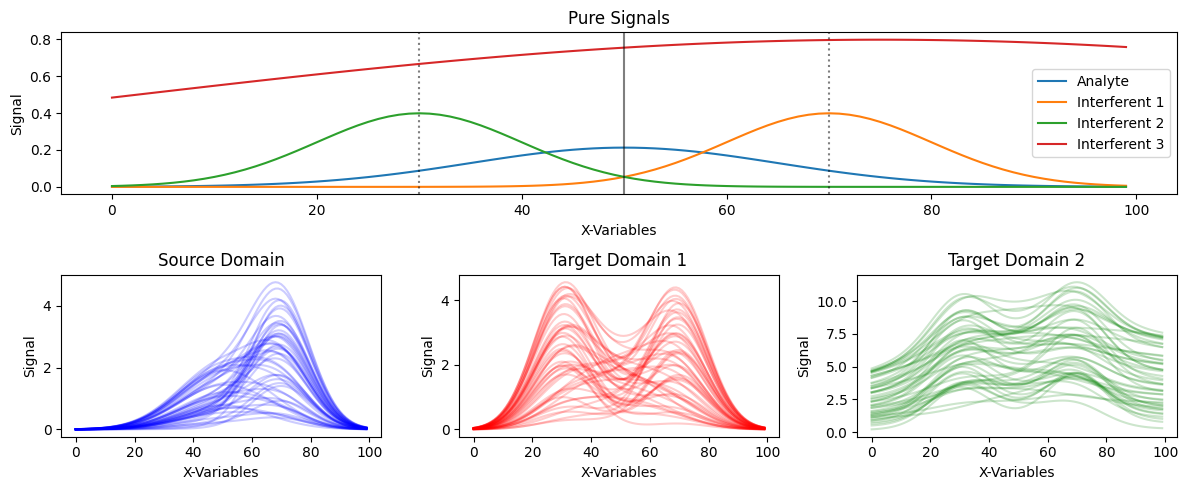

In [73]:
plt.figure(figsize=(12,5))
plt.subplot(211)
plt.plot(S1)
plt.plot(S2)
plt.plot(S3)
plt.plot(S4)
plt.legend(['Analyte','Interferent 1','Interferent 2', 'Interferent 3'])
plt.title('Pure Signals')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.axvline(x=50,linestyle='-',color='k',alpha=0.5)
plt.axvline(x=70,linestyle=':',color='k',alpha=0.5)
plt.axvline(x=30,linestyle=':',color='k',alpha=0.5)


plt.subplot(234)
plt.plot(Xs.T, 'b', alpha=0.2)
plt.title('Source Domain')
plt.xlabel('X-Variables')
plt.ylabel('Signal')

plt.subplot(235)
plt.plot(Xt1.T, 'r', alpha=0.2)
plt.title('Target Domain 1')
plt.xlabel('X-Variables')
plt.ylabel('Signal')

plt.subplot(236)
plt.plot(Xt2.T, 'g', alpha=0.2)
plt.title('Target Domain 2')
plt.xlabel('X-Variables')
plt.ylabel('Signal')
plt.tight_layout()
plt.show()

### Partial Least Squares Regression (PLS)
We will now try to model the analyte concentration in the Source domain given the simulated spectra and apply the model in the Target domains using standard PLS.

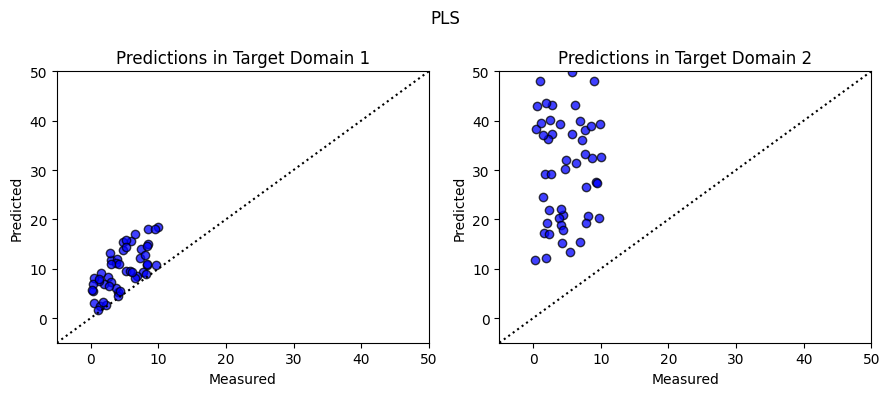

In [74]:
### Preliminaries
nr_comp = 2                         # Number of components
l = [0]                             # Regularization parameter
target_domains = [Xt1, Xt2]         # Target domains
ys = np.expand_dims(Cs[:, 0],1)     # Source domain concentrations
yt1 = np.expand_dims(Ct1[:, 0],1)   # Target domain 1 concentrations
yt2 = np.expand_dims(Ct2[:, 0],1)   # Target domain 2 concentrations

### Source model
m_pls = dipls(A=nr_comp, l=l)
m_pls.fit(Xs, ys, Xs, target_domains)
b_pls = m_pls.b_

yhat_plsT1 = m_pls.predict(Xt1)
yhat_plsT2 = m_pls.predict(Xt2)

error_plsT1 = fct.rmse(yt1, yhat_plsT1)
error_plsT2 = fct.rmse(yt2, yhat_plsT2)

min_ = -5
max_ = 50

# Plot
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(yt1, yhat_plsT1, color='b', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('Predictions in Target Domain 1')
plt.xlabel('Measured')
plt.ylabel('Predicted')

plt.subplot(122)
plt.scatter(yt2, yhat_plsT2, color='b', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('Predictions in Target Domain 2')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.suptitle('PLS')
plt.tight_layout()


As expected, the predictions of the Source model are not very accurate when applied in the Target domains because the latter contain contributions from additional interferents.

### Multiple Domain-invariant Partial Least Squares (mdi-PLS)
We will now include the Target domain data (without the corresponding analyte concentrations) and add some domain regularization to account for the additional interferents in the two target domains simultaneously.

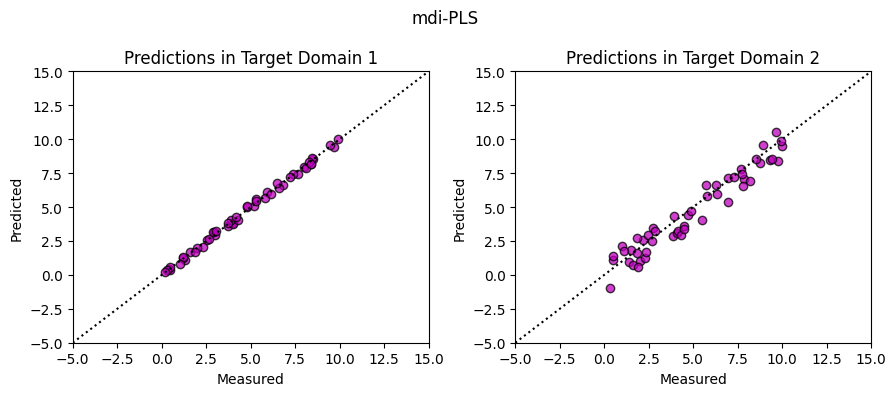

In [75]:
# Preliminaries
l = [100] # Regularization parameter

### mdi-PLS Model for target domain 1
m_diplsT1 = dipls(A=nr_comp, l=l, target_domain=1)
m_diplsT1.fit(Xs, ys, Xs, target_domains)
b_diplsT1 = m_diplsT1.b_
yhat_diplsT1 = m_diplsT1.predict(Xt1)

error_diplsT1 = fct.rmse(yt1, yhat_diplsT1)

### mdi-PLS Model for target domain 2
m_diplsT2 = dipls(A=nr_comp, l=l, target_domain=2)
m_diplsT2.fit(Xs, ys, Xs, target_domains)
b_diplsT2 = m_diplsT2.b_
yhat_diplsT2 = m_diplsT2.predict(Xt2)

error_diplsT2 = fct.rmse(yt2, yhat_diplsT2)

min_ = -5
max_ = 15

# Plot
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(yt1, yhat_diplsT1, color='m', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('Predictions in Target Domain 1')
plt.xlabel('Measured')
plt.ylabel('Predicted')

plt.subplot(122)
plt.scatter(yt2, yhat_diplsT2, color='m', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('Predictions in Target Domain 2')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.suptitle('mdi-PLS')
plt.tight_layout()

The model now predicts the analyte concentrations accurately in both Target domains! Note that we have only included X but no Y data from the Target domains (along with the X and Y data from the Source domain) to find good models for the Target domains. It is important to note that mdi-PLS produces separate models for each Target domain. By specifiying the 'target_domain' parameter, we can determine in which Target domain we want the model to be applied. 
    
```python
m_diplsT1 = dipls(Xs, ys, Xs, target_domains, nr_comp)
m_diplsT1.fit(l=l, target_domain=1)
```

produces a model for Target domain 1 whereas

```python
m_diplsT2 = dipls(Xs, ys, Xs, target_domains, nr_comp)
m_diplsT2.fit(l=l, target_domain=2)
```
preduces a model for Target domain 2. If we don't know from which domain the test data is sampled it is advisable to use target_domain=0.

Let's try to understand how mdi-PLS improves the predictions in the Target domains. To this end, we will take a look at the projections of Source and Target domain data onto the latent variable (LV) spaces spanned by a PCA model based upon spectra from all domains and the mdi-PLS model.

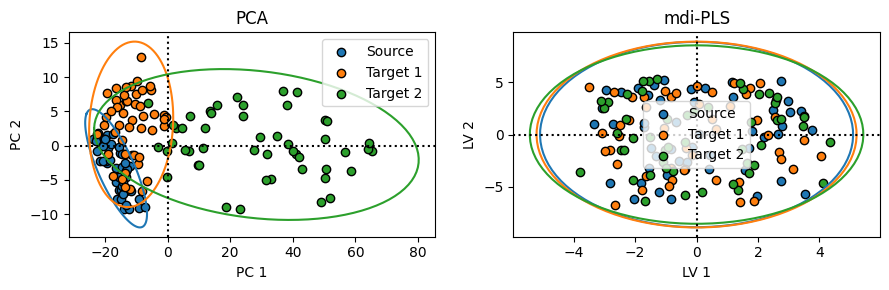

In [76]:
### PCA
X = np.vstack([Xs, Xt1, Xt2])
X = X[:,...] - np.mean(X, 0)
U,S,V = np.linalg.svd(X)
T = U[:, :100]@np.diag(S)

plt.figure(figsize=(9, 3))
plt.subplot(121)
a = plt.scatter(T[:50, 0], T[:50, 1], edgecolors='k')
el = fct.hellipse(T[:50, :2])
plt.plot(el[0,:],el[1,:])

b = plt.scatter(T[51:100, 0], T[51:100, 1], edgecolors='k')
el = fct.hellipse(T[51:100, :2])
plt.plot(el[0,:],el[1,:])

c = plt.scatter(T[101:, 0], T[101:, 1], edgecolors='k')
el = fct.hellipse(T[101:, :2])
plt.plot(el[0,:],el[1,:])

plt.xlabel('PC 1')
plt.ylabel('PC 2')

ax = plt.gca()
ax.axhline(y=0,color='k',linestyle=':')
ax.axvline(x=0,color='k',linestyle=':')

plt.legend([a, b, c], ['Source', 'Target 1', 'Target 2'])
plt.title('PCA')


### mdi-PLS
nr_comp = 2
l =  [100]
target_domains = [Xt1, Xt2]
ys = np.expand_dims(Cs[:, 0],1)
yt1 = np.expand_dims(Ct1[:, 0],1)
yt2 = np.expand_dims(Ct2[:, 0],1)

m_dipls = dipls(A=nr_comp, l=l, target_domain=0)
m_dipls.fit(Xs, ys, Xs, target_domains)

plt.subplot(122)
a = plt.scatter(m_dipls.Ts_[:, 0], m_dipls.Ts_[:, 1], edgecolors='k')
el = fct.hellipse(m_dipls.Ts_)
plt.plot(el[0,:],el[1,:])

b = plt.scatter(m_dipls.Tt_[0][:, 0], m_dipls.Tt_[0][:, 1], edgecolors='k')
el = fct.hellipse(m_dipls.Tt_[0])
plt.plot(el[0,:],el[1,:])

c = plt.scatter(m_dipls.Tt_[1][:, 0], m_dipls.Tt_[1][:, 1], edgecolors='k')
el = fct.hellipse(m_dipls.Tt_[1])
plt.plot(el[0,:],el[1,:])

ax = plt.gca()
ax.axhline(y=0,color='k',linestyle=':')
ax.axvline(x=0,color='k',linestyle=':')

plt.xlabel('LV 1')
plt.ylabel('LV 2')
plt.title('mdi-PLS')
plt.legend([a, b, c], ['Source', 'Target 1', 'Target 2'])

plt.tight_layout()
plt.show()


We can see that the distributions of Source and Target domain scores (i.e. the projections on the LV spaces) are well aligned in the mdi-PLS model. Modelling the analyte in the Source domain using LVs for which the data from the Source and Target domains look *as if they were sampled from the same underlying distribution* improves generalization across the domains. This follows directly from the *theory of learning from different domains* (Ben-David et al. Mach. Learn. 2010).

Let's now look at the regression coefficients of the PLS and mdi-PLS models.

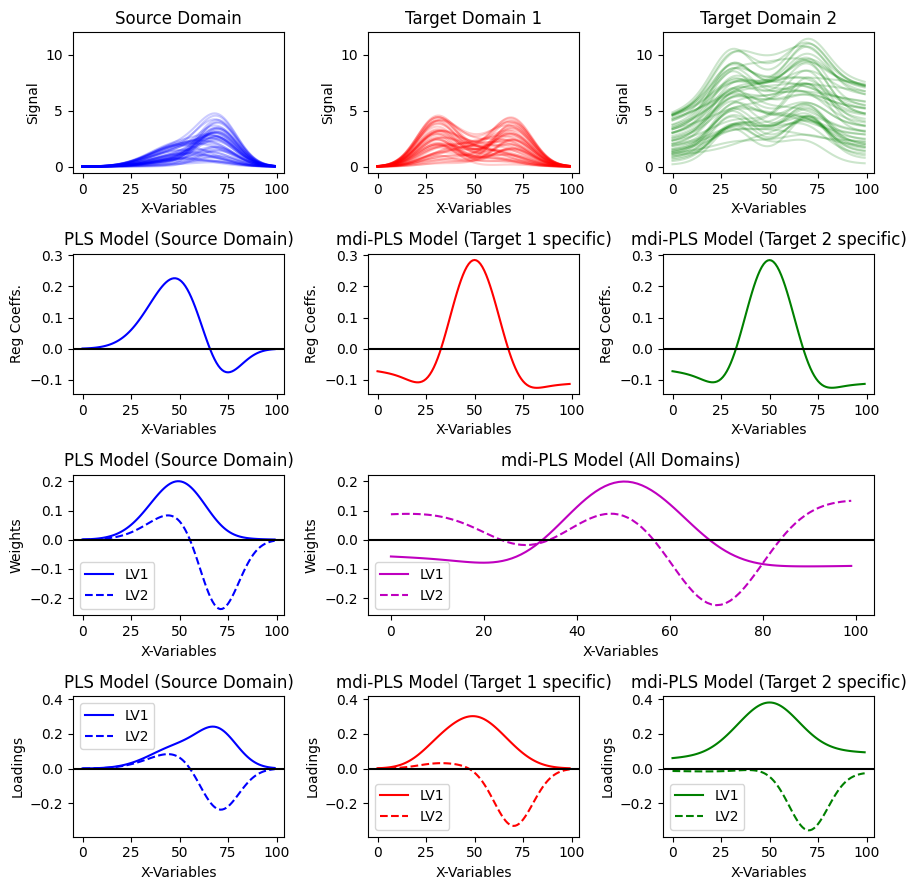

In [77]:
fig = plt.figure(figsize=(9, 9), constrained_layout=True)
gs = GridSpec(4, 3, figure=fig)

# create sub plots as grid
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1], sharey=ax4)
ax5_1 = fig.add_subplot(gs[1, 2], sharey=ax4)
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1:], sharey=ax6)
ax8 = fig.add_subplot(gs[3, 0])
ax9 = fig.add_subplot(gs[3, 1], sharey=ax8)
ax10 = fig.add_subplot(gs[3, 2], sharey=ax8)

# Raw data
ax1.plot(Xs.T, 'b', alpha=0.2)
ax1.set_title('Source Domain')
ax1.set_xlabel('X-Variables')
ax1.set_ylabel('Signal')

ax2.plot(Xt1.T, 'r', alpha=0.2)
ax2.set_title('Target Domain 1')
ax2.set_xlabel('X-Variables')
ax2.set_ylabel('Signal')

ax3.plot(Xt2.T, 'g', alpha=0.2)
ax3.set_title('Target Domain 2')
ax3.set_xlabel('X-Variables')
ax3.set_ylabel('Signal')

# Regression coefficients
ax4.plot(b_pls, 'b')
ax4.set_ylabel('Reg Coeffs.')
ax4.set_xlabel('X-Variables')
ax4.set_title('PLS Model (Source Domain)')
ax4.axhline(y=0, color='k')

ax5.plot(b_diplsT1, 'r')
ax5.set_ylabel('Reg Coeffs.')
ax5.set_xlabel('X-Variables')
ax5.set_title('mdi-PLS Model (Target 1 specific)')
ax5.axhline(y=0, color='k')

ax5_1.plot(b_diplsT2, 'g')
ax5_1.set_ylabel('Reg Coeffs.')
ax5_1.set_xlabel('X-Variables')
ax5_1.set_title('mdi-PLS Model (Target 2 specific)')
ax5_1.axhline(y=0, color='k')

# Weights
ax6.plot(m_pls.W_[:, 0], 'b')
ax6.plot(m_pls.W_[:, 1], '--', color='b')
ax6.set_ylabel('Weights')
ax6.legend(['LV1','LV2'])
ax6.set_xlabel('X-Variables')
ax6.set_title('PLS Model (Source Domain)')
ax6.axhline(y=0, color='k')

ax7.plot(m_diplsT1.W_[:, 0],'m')
ax7.plot(m_diplsT1.W_[:, 1], '--', color='m')
ax7.set_ylabel('Weights')
ax7.legend(['LV1','LV2'])
ax7.set_xlabel('X-Variables')
ax7.set_title('mdi-PLS Model (All Domains)')
ax7.axhline(y=0, color='k')

# Loadings
ax8.plot(m_pls.Ps_[:, 0], 'b')
ax8.plot(m_pls.Ps_[:, 1], '--', color='b')
ax8.set_ylabel('Loadings')
ax8.legend(['LV1','LV2'])
ax8.set_xlabel('X-Variables')
ax8.set_title('PLS Model (Source Domain)')
ax8.axhline(y=0, color='k')

ax9.plot(m_diplsT1.Pt_[0][:, 0],'r')
ax9.plot(m_diplsT1.Pt_[0][:, 1], '--', color='r')
ax9.set_ylabel('Loadings')
ax9.legend(['LV1','LV2'])
ax9.set_xlabel('X-Variables')
ax9.set_title('mdi-PLS Model (Target 1 specific)')
ax9.axhline(y=0, color='k')

ax10.plot(m_diplsT2.Pt_[1][:, 0], 'g')
ax10.plot(m_diplsT2.Pt_[1][:, 1], '--', color='g')
ax10.set_ylabel('Loadings')
ax10.legend(['LV1','LV2'])
ax10.set_xlabel('X-Variables')
ax10.set_title('mdi-PLS Model (Target 2 specific)')
ax10.axhline(y=0, color='k')

plt.tight_layout()
plt.show()


The first column shows the spectra, regression coefficients, weights and loadings of an ordinary PLS model using only the source domain data, while the second and third columns show the same quantities for mdi-PLS models that include the spectra from the two target domains. Note that the model has a common set of weights but distinct loadings and regression coefficients that are specific to each target domain.

Let's now take a look how the 'target_domain' parameter influences the predictions in Target domain 2.

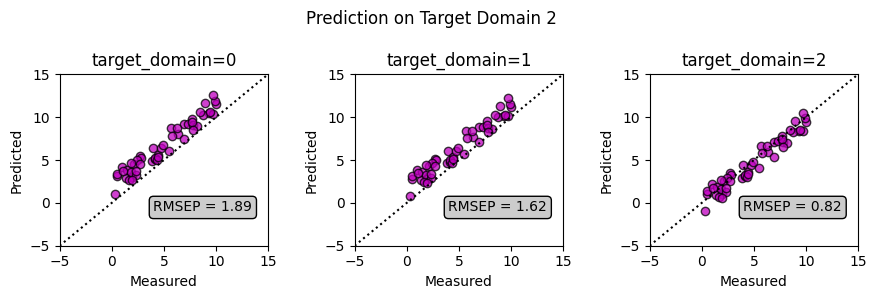

In [78]:
# Preliminaries
l = [100] # Regularization parameter
min_ = -5 # Min value for plot
max_ = 15 # Max value for plot
bbox = dict(boxstyle="round", fc="0.8") # Box style for text

### mmdi-PLS Model with target_domain=0
m_diplsT2 = dipls(A=nr_comp, l=l, target_domain=0)
m_diplsT2.fit(Xs, ys, Xs, target_domains)

b_diplsT2 = m_diplsT2.b_
yhat_diplsT2 = m_diplsT2.predict(Xt2)

error_diplsT2 = fct.rmse(yt2, yhat_diplsT2)

# Plot
plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.scatter(yt2, yhat_diplsT2, color='m', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('target_domain=0')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.text(4, -1, 'RMSEP = %.2f' % error_diplsT2, bbox=bbox)

### mmdi-PLS Model with target_domain=1
m_diplsT2 = dipls(A=nr_comp, l=l, target_domain=1)
m_diplsT2.fit(Xs, ys, Xs, target_domains)

b_diplsT2 = m_diplsT2.b_
yhat_diplsT2 = m_diplsT2.predict(Xt2)

error_diplsT2 = fct.rmse(yt2, yhat_diplsT2)

# Plot
plt.subplot(132)
plt.scatter(yt2, yhat_diplsT2, color='m', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('target_domain=1')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.text(4, -1, 'RMSEP = %.2f' % error_diplsT2, bbox=bbox)


### mmdi-PLS Model with target_domain=2
m_diplsT2 = dipls(A=nr_comp, l=l, target_domain=2)
m_diplsT2.fit(Xs, ys, Xs, target_domains)

b_diplsT2 = m_diplsT2.b_
yhat_diplsT2 = m_diplsT2.predict(Xt2)

error_diplsT2 = fct.rmse(yt2, yhat_diplsT2)

# Plot
plt.subplot(133)
plt.scatter(yt2, yhat_diplsT2, color='m', edgecolor='k',alpha=0.75)
plt.plot([min_,max_], [min_,max_], color='k', linestyle=":")
plt.xlim([min_,max_])
plt.ylim([min_,max_])
plt.title('target_domain=2')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.text(4, -1, 'RMSEP = %.2f' % error_diplsT2, bbox=bbox)
plt.suptitle('Prediction on Target Domain 2')
plt.tight_layout()

As evident from the above plot, it is crucial to specify the correct 'target_domain' parameter to obtain the most accurate predictions in the Target domains. If we don't know from which domain the test data is sampled it is advisable to use target_domain=0.